In [2]:
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pandas as pd
import seaborn as sns
from typing import Callable
import matplotlib as mpl
import numpy as np

# Apply the default theme
# sns.set_theme()
sns.set_style("whitegrid")
mpl.rcParams["figure.dpi"] = 150

import sys

sys.path.append("..")

from src.data.promptloader import (
    PromptLoader,
    GigawordDataLoader,
    DailymailDataLoader,
    TweetQADataLoader,
    RottenTomatoesDataLoader,
    MMLUAbstractAlgebraDataLoader,
    GSM8KDataLoader,
    MMLUHumanAgingDataLoader,
)
from src.eval.eval_metric import evaluate

plt.rcParams.update({"font.size": 12})
plt.rc("text", usetex=True)
plt.rc("font", family="serif")
plt.rcParams.update({
    # 'font.size': 8,
    # 'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

load_dotenv()

True

In [3]:
def get_results(folder: Path, all_reference_data: list[str], use_cached: bool = True):
    

    pred_file = Path(folder) / "predictions.json"

    if not pred_file.is_file():
        print(f"Skipping {str(folder)}")
        return {}
    
    eval_idxs_file = Path(folder) / "eval_idxs.json"
    if eval_idxs_file.is_file():
        ref_data = [all_reference_data[i] for i in json.load(open(eval_idxs_file, "r"))]
    else:
        ref_data = all_reference_data
    
    # Calculate metrics
    return evaluate(pred_file, ref_data, use_cached=use_cached)

In [4]:
def get_results_for_evalset(
    eval_set: str,
    all_ref_data: list[str],
    model_folder_names=["mistral-7b", "llama-7b", "gpt3.5", "gpt4"],
    experiment_path=Path("../experiments/"),
    use_cached: bool = True,
    iterative=True,
    seed = False
):
    results = []
    for model_folder in model_folder_names:
        eval_folder: Path = Path(experiment_path) / model_folder / f"eval_data_{eval_set}"
        if not eval_folder.is_dir():
            print(f"Model: {model_folder} is missing eval set {str(eval_folder)}")
            continue
        
        # extract results in parallel for each in context set
        for in_ctxt_folder in eval_folder.iterdir():
            res = []
            for num_examples_folder in in_ctxt_folder.iterdir():
                f = num_examples_folder / "iterative" if iterative else num_examples_folder
                results_folders = []
                if seed:
                    for seed_folder in f.iterdir():
                        if not seed_folder.is_dir():
                            continue
                        if not "seed" in seed_folder.name:
                            continue
                        results_folders.append(seed_folder)
                else:
                    results_folders.append(f)
                    
                for res_folder in results_folders:
                    try:
                        res.append(get_results(res_folder, all_ref_data, use_cached=use_cached))
                    except Exception as e:
                        print(f"Error processing {str(res_folder)}")
                        print(e)


            res = [r for r in res if r]
            results.extend(res)
    return results

In [52]:
# Assign colors to incontext_set

# Load pastel colors
pastel_colors = sns.color_palette("Set2", 7)
# print(pastel_colors)

dataset_color = {
    "tweetqa": pastel_colors[0],
    "gigaword": pastel_colors[1],
    "dailymail": pastel_colors[2],
    "rotten_tomatoes": pastel_colors[3],
    "mmluaa": pastel_colors[4],
    "gsm8k": pastel_colors[5],
    "mmlu-age": pastel_colors[6],
}

dataset_label = {
    "tweetqa": "TweetQA",
    "gigaword": "Gigaword",
    "dailymail": "Dailymail",
    "rotten_tomatoes": "Rotten Tomatoes",
    "mmluaa": "MMLU Abstract Algebra",
    "gsm8k": "GSM8K",
    "mmlu-age": "MMLU Human Aging",
}

model_label = {
    "mistral-7b": "Mistral-7B",
    "llama-7b": "Llama-7B",
    "gpt3.5": "GPT-3.5",
    "gpt4": "GPT-4",
    "mixtral": "Mixtral",
}

In [58]:
def plot_df_metrics_per_model(
  results_df: pd.DataFrame,
  metrics: list[str],
  save_path: Path = None,
  title: str = None,
  adjust_func: Callable = lambda _: _,
  eval_set: str = "",
  legend_anchor: tuple[float, float] = (0.95, 1.5),
  legend_axs = (-1, 0),
  xlim: tuple = (0, 6),
  legend_rows: int = 2,
  save_png: bool = False,
):
    """Plot metrics for each dataset and model
    
    axis per model
    line per dataset

    x-axis: number of examples
    y-axis: metric
    """
    for metric in metrics:
        assert metric in results_df.columns, f"Metric {metric} not in dataframe"

    num_metrics = len(metrics)
    num_models = len(results_df["model"].unique())
    fig, axs = plt.subplots(
        figsize=(12.5, 2 * num_metrics), 
        nrows=num_metrics, 
        ncols=num_models, 
        sharex=True, 
        sharey='row', 
        squeeze=False,
    )

    for y_idx, (metric, axs_y) in enumerate(zip(metrics, axs)):
        for x_idx, (ax, (model, df)) in enumerate(zip(axs_y, results_df.groupby("model"))):
            for (inctxt, df_inctxt) in df.groupby("incontext_set"):
                df_inctxt = df_inctxt.sort_values("num_examples")

                g = sns.lineplot(
                    data=df_inctxt,
                    x="num_examples",
                    y=metric,
                    ax=ax,
                    label=dataset_label[inctxt],
                    color=dataset_color[inctxt],
                    marker="X",
                    errorbar=("pi", 100)
                )

                # Remove ylabel
                # ax.set_ylabel("")
                # if x_idx == 0:
                #     ax.set_ylabel(metric)

                ax.yaxis.set_tick_params(labelbottom=True)
                
                if y_idx == 0:
                    ax.set_title(model_label[model])
                ax.legend_.remove()

            ax.set_xlim(xlim)
            # ax.set_xlabel(r"History Length $L$")
            ax.set_xlabel("")

    # Add legend
    # plot_dataset_models_legend(axs[-1, 0])
    legend = axs[legend_axs].legend(
        loc="upper left", 
        bbox_to_anchor=legend_anchor, 
        ncol=len(results_df["incontext_set"].unique()) // legend_rows,
        # nrow=2,
        fancybox=True,
        shadow=True,
    )
    legend.set_title("Conversation History Task")
    # Colour eval set label
    if eval_set:
        for text in legend.get_texts():
            if text.get_text() == dataset_label[eval_set]:
                # make bold
                # text.set_weight("bold")
                # text.set_color("red")
                text.set_text(rf"\textbf{{{text.get_text()}}}")
    if title:
        fig.suptitle(title)
    # plt.tight_layout()
    adjust_func(axs)
    fig.text(0.5, -0.1, r'Conversation History Length $L$', ha='center')
    if save_path:
        save_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight")
        # Also save as png
        if save_png:
            plt.savefig(save_path.with_suffix(".png"), bbox_inches="tight")
    plt.show()
            

In [11]:
def df_metric_pct_change(df: pd.DataFrame, metric: str):
    """Calculate the percentage change of a metric"""
    df[f"{metric}_pct_change"] = 0.
    for row in df[["model", "incontext_set", metric]].itertuples():
        baseline_metric = df[(df["model"] == row.model) & (df["incontext_set"] == row.incontext_set) & (df["num_examples"] == 0)][metric].values[0]
        df.loc[row.Index, f"{metric}_pct_change"] = (row[-1] - baseline_metric) / baseline_metric * 100
    return df

### Evaluate on RT

In [5]:
rt = RottenTomatoesDataLoader()
rt_reference_data = rt.load_test_reference()
rt_results = get_results_for_evalset(
    "rotten_tomatoes",
    rt_reference_data,
    use_cached=True,
    iterative=True,
    seed=True,
)
rt_results_df = pd.DataFrame.from_records(rt_results)
rt_results_df.head()

,matches,failed,total,seed,model,incontext_set,num_examples,base_likelihood,final_likelihood,ref_likelihood
0,948,15,1066,100,mistral-7b,rotten_tomatoes,3,None,None,None
1,947,15,1066,1000,mistral-7b,rotten_tomatoes,3,None,None,None
2,946,14,1066,10000,mistral-7b,rotten_tomatoes,3,None,None,None
3,957,11,1066,100,mistral-7b,rotten_tomatoes,6,None,None,None
4,954,13,1066,1000,mistral-7b,rotten_tomatoes,6,None,None,None


In [34]:
# df = rt_results_df
# df["acc"] = df["matches"] / df["total"]
# df.groupby(["model", "incontext_set", "num_examples"]).mean()

matches     failed   total  \
model      incontext_set   num_examples                                  
llama-7b   gigaword        0             932.000000   1.000000  1066.0   
                           3             952.000000   1.666667  1066.0   
                           6             949.000000   1.333333  1066.0   
           mmluaa          0             932.000000   1.000000  1066.0   
                           3             880.666667   0.666667  1066.0   
                           6             882.333333   1.000000  1066.0   
           rotten_tomatoes 0             932.000000   1.000000  1066.0   
                           3             952.666667  17.333333  1066.0   
                           6             955.666667  15.666667  1066.0   
           tweetqa         0             932.000000   1.000000  1066.0   
                           3             957.000000   2.666667  1066.0   
                           6             957.333333   2.000000  1066.0   
mistral-7b gigaword        0             924.000000   1.000000  1066.0   
                           3             918.000000   0.000000  1066.0   
                           6             916.666667   0.000000  1066.0   
           mmluaa          0             924.000000   1.000000  1066.0   
                           3             933.666667   0.000000  1066.0   
                           6             936.333333   0.000000  1066.0   
           rotten_tomatoes 0             924.000000   1.000000  1066.0   
                           3             947.000000  14.666667  1066.0   
                           6             953.333333  12.666667  1066.0   
           tweetqa         0             924.000000   1.000000  1066.0   
                           3             911.666667   0.000000  1066.0   
                           6             912.666667   0.000000  1066.0   

                                           seed base_likelihood  \
model      incontext_set   num_examples                           
llama-7b   gigaword        0             3700.0             NaN   
                           3             3700.0             NaN   
                           6             3700.0             NaN   
           mmluaa          0             3700.0             NaN   
                           3             3700.0             NaN   
                           6             3700.0             NaN   
           rotten_tomatoes 0             3700.0             NaN   
                           3             3700.0             NaN   
                           6             3700.0             NaN   
           tweetqa         0             3700.0             NaN   
                           3             3700.0             NaN   
                           6             3700.0             NaN   
mistral-7b gigaword        0             3700.0             NaN   
                           3             3700.0             NaN   
                           6             3700.0             NaN   
           mmluaa          0             3700.0             NaN   
                           3             3700.0             NaN   
                           6             3700.0             NaN   
           rotten_tomatoes 0             3700.0             NaN   
                           3             3700.0             NaN   
                           6             3700.0             NaN   
           tweetqa         0             3700.0             NaN   
                           3             3700.0             NaN   
                           6             3700.0             NaN   

                                        final_likelihood ref_likelihood  \
model      incontext_set   num_examples                                   
llama-7b   gigaword        0                         NaN            NaN   
                           3                         NaN            NaN   
                           6                         NaN            NaN   
 

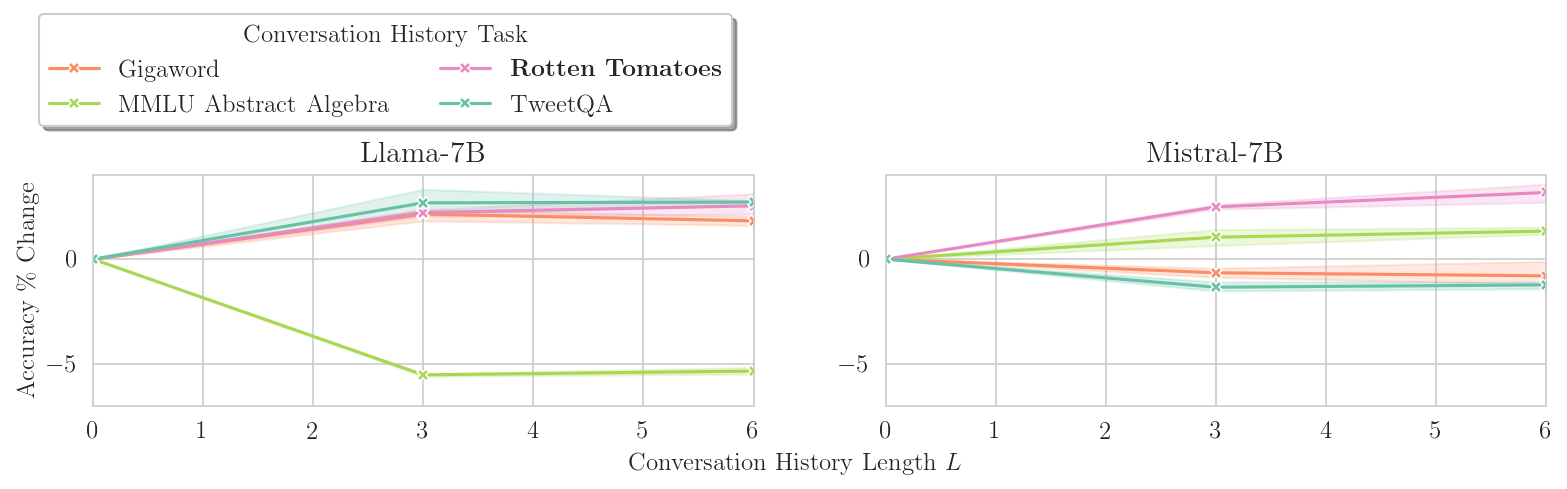

In [59]:
label = r"Accuracy \% Change"
df = rt_results_df.rename(columns={"acc_pct_change": label})
plot_df_metrics_per_model(
  df, 
  [label], 
  # save_path=Path("rt/accuracy.pdf"), 
  # title="MMLU Abstract Algebra Results",
  eval_set="rotten_tomatoes",
  legend_anchor=(-1.3, 1.75),
  adjust_func=lambda axs: axs[0, 0].set_ylim(-7, 4),
  legend_axs=(-1, 1),
  # save_png=True,
)

### Distance Metric: Format (MCQ, Essay)

RT, MMLU, TweetQA, Gigaword

Results df: num_examples, inctxt, model, (seed), 

In [48]:
df = rt_results_df

df["acc"] = df["matches"] / df["total"]
df = df_metric_pct_change(df, "acc")

# remove num_examples == 0
df = df[df["num_examples"] > 0]

mmlu_ranks = {
  "rotten_tomatoes": 1,
  "mmluaa": 2,
  "tweetqa": 3,
  "gigaword": 4,
}
df["inctxt_rank"] = df["incontext_set"].apply(lambda inctxt: mmlu_ranks[inctxt])
df.head()

/tmp/ipykernel_22616/15370927.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["inctxt_rank"] = df["incontext_set"].apply(lambda inctxt: mmlu_ranks[inctxt])


,matches,failed,total,seed,model,incontext_set,num_examples,base_likelihood,final_likelihood,ref_likelihood,acc,acc_pct_change,inctxt_rank
0,948,15,1066,100,mistral-7b,rotten_tomatoes,3,None,None,None,0.889306,2.597403,1
1,947,15,1066,1000,mistral-7b,rotten_tomatoes,3,None,None,None,0.888368,2.489177,1
2,946,14,1066,10000,mistral-7b,rotten_tomatoes,3,None,None,None,0.887430,2.380952,1
3,957,11,1066,100,mistral-7b,rotten_tomatoes,6,None,None,None,0.897749,3.571429,1
4,954,13,1066,1000,mistral-7b,rotten_tomatoes,6,None,None,None,0.894934,3.246753,1


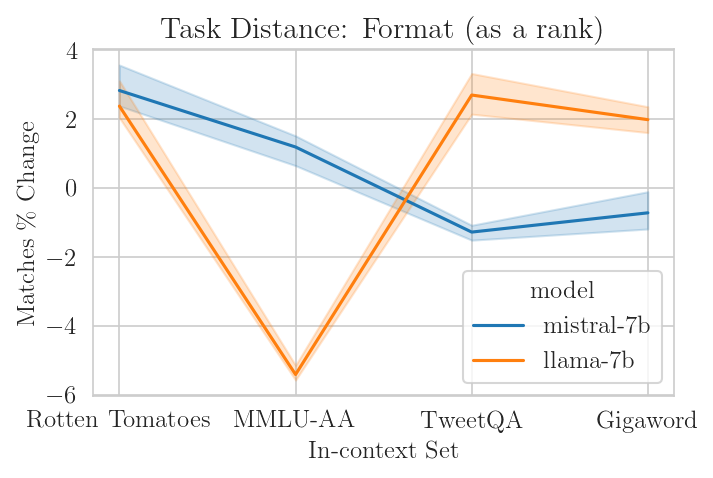

In [49]:
# plot rank against matches_pct_change
fig, ax = plt.subplots(figsize=(5, 3))
sns.lineplot(
    data=df,
    x="inctxt_rank",
    y="acc_pct_change",
    hue="model",
    ax=ax,
    errorbar=("pi", 100),
)
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(["Rotten Tomatoes", "MMLU-AA", "TweetQA", "Gigaword"])
# rotate xlabels
# plt.xticks(rotation=10)
ax.set_xlabel("In-context Set")
ax.set_ylabel(r"Matches \% Change")
ax.set_title("Task Distance: Format (as a rank)")
plt.show()

### MMLU AA

In [7]:
aa = MMLUAbstractAlgebraDataLoader()
aa_ref_data = aa.load_test_reference()
aa_results = get_results_for_evalset(
    "mmluaa",
    aa_ref_data,
    use_cached=True,
    iterative=True,
    seed=True,
)
aa_results_df = pd.DataFrame(aa_results)

print(len(aa_results_df))
aa_results_df.head()

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Reference probabilities not found at ../experiments/mistral-7b/eval_data_mmluaa/incontext_data_rotten_tomatoes/num_examples_3/iterative/seed_100/base_probabilities.pkl
Reference probabilities not found at ../experiments/mistral-7b/eval_data_mmluaa/incontext_data_rotten_tomatoes/num_examples_3/iterative/seed_100/final_probabilities.pkl
Reference probabilities not found at ../experiments/mistral-7b/eval_data_mmluaa/incontext_data_rotten_tomatoes/num_examples_3/iterative/seed_100/ref_probabilities.pkl
Reference probabilities not found at ../experiments/mistral-7b/eval_data_mmluaa/incontext_data_rotten_tomatoes/num_examples_3/iterative/seed_1000/base_probabilities.pkl
Reference probabilities not found at ../experiments/mistral-7b/eval_data_mmluaa/incontext_data_rotten_tomatoes/num_examples_3/iterative/seed_1000/final_probabilities.pkl
Reference probabilities not found at ../experiments/mistral-7b/eval_data_mmluaa/incontext_data_rotten_tomatoes/num_examples_3/iterative/seed_1000/ref_probabi

,matches,failed,total,seed,model,incontext_set,num_examples,base_likelihood,final_likelihood,ref_likelihood
0,26,0,100,100,mistral-7b,rotten_tomatoes,3,None,None,None
1,27,0,100,1000,mistral-7b,rotten_tomatoes,3,None,None,None
2,23,0,100,10000,mistral-7b,rotten_tomatoes,3,None,None,None
3,26,0,100,100,mistral-7b,rotten_tomatoes,6,None,None,None
4,27,0,100,1000,mistral-7b,rotten_tomatoes,6,None,None,None


In [9]:
np.unique(aa_results_df["incontext_set"])

array(['gigaword', 'mmluaa', 'rotten_tomatoes', 'tweetqa'], dtype=object)

In [60]:
aa_results_df["acc"] = aa_results_df["matches"] / aa_results_df["total"]
aa_results_df = df_metric_pct_change(aa_results_df, "acc")

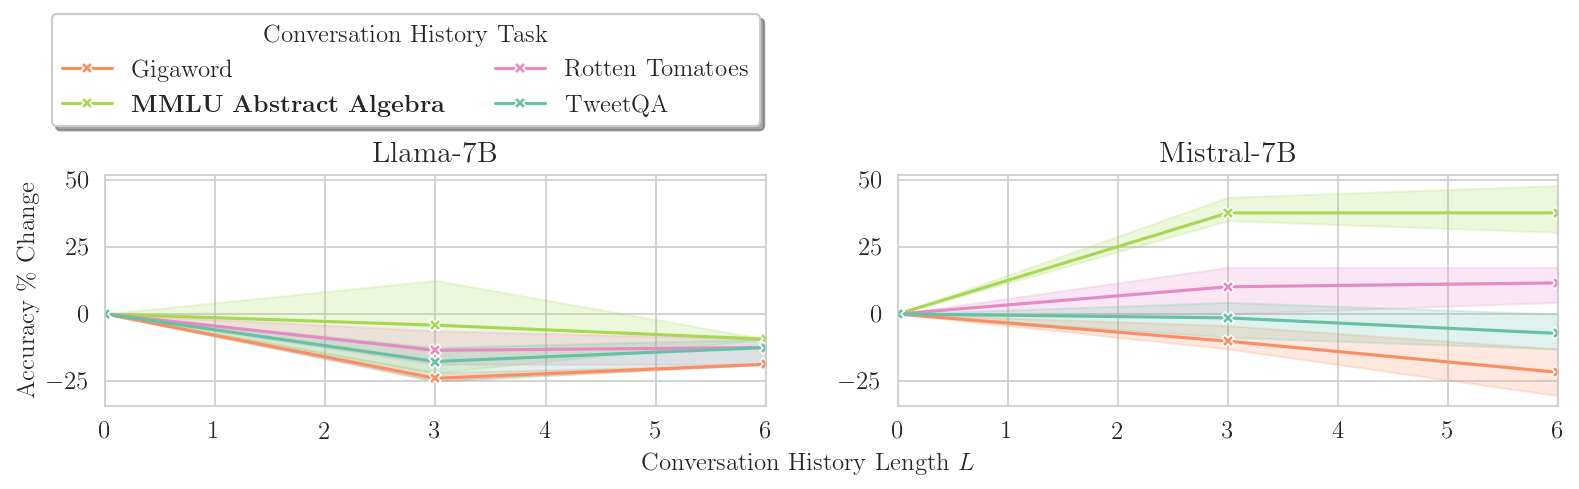

In [62]:
label = r"Accuracy \% Change"
df = aa_results_df.rename(columns={"acc_pct_change": label})
plot_df_metrics_per_model(
  df, 
  [label], 
  # save_path=Path("rt/accuracy.pdf"), 
  # title="MMLU Abstract Algebra Results",
  eval_set="mmluaa",
  legend_anchor=(-1.3, 1.75),
  # adjust_func=lambda axs: axs[0, 0].set_ylim(-7, 4),
  legend_axs=(-1, 1),
  # save_png=True,
)

### Length of Conversation vs Accuracy

### Distance Metric: Format (MCQ, Essay)

MMLU, RT, TweetQA, Gigaword

Results df: num_examples, inctxt, model, (seed), 

In [50]:
df = aa_results_df

df["acc"] = df["matches"] / df["total"]
df = df_metric_pct_change(df, "acc")

# remove num_examples == 0
df = df[df["num_examples"] > 0]

mmlu_ranks = {
  "mmluaa": 1,
  "rotten_tomatoes": 2,
  "tweetqa": 3,
  "gigaword": 4,
}
df["inctxt_rank"] = df["incontext_set"].apply(lambda inctxt: mmlu_ranks[inctxt])
df.head()

/tmp/ipykernel_22616/1501764709.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["inctxt_rank"] = df["incontext_set"].apply(lambda inctxt: mmlu_ranks[inctxt])


,matches,failed,total,seed,model,incontext_set,num_examples,base_likelihood,final_likelihood,ref_likelihood,inctxt_rank,matches_pct_change,acc,acc_pct_change
0,26,0,100,100,mistral-7b,rotten_tomatoes,3,None,None,None,2,13.043478,0.26,13.043478
1,27,0,100,1000,mistral-7b,rotten_tomatoes,3,None,None,None,2,17.391304,0.27,17.391304
2,23,0,100,10000,mistral-7b,rotten_tomatoes,3,None,None,None,2,0.000000,0.23,0.000000
3,26,0,100,100,mistral-7b,rotten_tomatoes,6,None,None,None,2,13.043478,0.26,13.043478
4,27,0,100,1000,mistral-7b,rotten_tomatoes,6,None,None,None,2,17.391304,0.27,17.391304


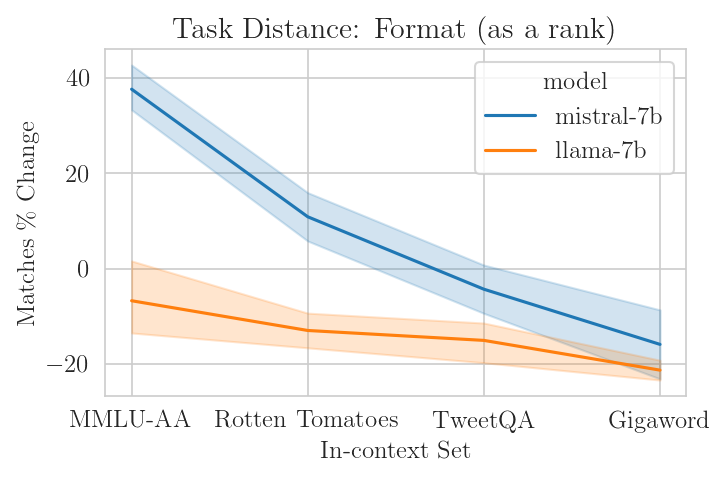

In [51]:
# plot rank against matches_pct_change
fig, ax = plt.subplots(figsize=(5,3))
sns.lineplot(data=df, x="inctxt_rank", y="acc_pct_change", hue="model", ax=ax)
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(["MMLU-AA", "Rotten Tomatoes", "TweetQA", "Gigaword"])
# rotate xlabels
# plt.xticks(rotation=10)
ax.set_xlabel("In-context Set")
ax.set_ylabel(r"Matches \% Change")
ax.set_title("Task Distance: Format (as a rank)")
plt.show()

### Distance Metric: Length of Question (by number of tokens)

Results df: num_examples, inctxt, model, (seed), 